# **COVID-19 DETECTION IN XRAY IMAGES**
## NATIONAL COLLEGE OF IRELAND 
## POSTGRAD IN SCIENCE IN DATA ANALYTICS
### Project for Data Mining and Machine Learning II
### Authors:
### Batlle, Jordi (x17133246)
### Blaszczyk, Grzegorz (x18199160)
### Kelly, David (x16116038)
### Lkham, Batsuuri (x19164815)

**IMPORT LIBRARIES AND SETUP**

In [ ]:
import numpy as np
from numpy.random import seed
seed(20)

import tensorflow as tf
tf.random.set_seed(30)

from google.colab import files
import warnings
warnings.filterwarnings('ignore')



import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' %x)

import matplotlib.pyplot as plt
from matplotlib import pyplot, image
from pylab import rcParams
import seaborn as sb
%matplotlib inline
plt.rcParams['font.family'] = "serif"
sb.set_style('whitegrid')

import seaborn as sns

import os
from os import listdir
import shutil

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras. models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AvgPool2D, Activation, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

from PIL import Image, ImageOps

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight

import random

 **GET DATA**

In order to download data directly from Kaggle to colab we need to have the Kaggle API token downladed. To this log in to Kaggle, go to my account section and click "Create API Token" Button. When we run the below code it will allow us to choose file. Go to where you have saved token and upload.

In [ ]:
#upload kaggle API token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dkelly","key":"3ba2b683a1ad27af22979a3f23552f33"}'}

The below code puts the token to where the API framework expects it and limits read credentials

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Our project relates to the coronhack dataset on kaggle. The below code lists kaggle datasets related to coronahack

In [ ]:
#list kaggle datasets related to 'CoronaHack'
!kaggle datasets list -s CoronaHack

ref                                                 title                            size  lastUpdated          downloadCount  
--------------------------------------------------  -------------------------------  ----  -------------------  -------------  
praveengovi/coronahack-chest-xraydataset            CoronaHack -Chest X-Ray-Dataset   1GB  2020-03-20 01:26:40           5590  
konstantinosalvertos/corona-hack-chest-xraydataset  coronahack-chest-xraydataset     25KB  2020-06-27 13:10:20              0  


At the time of writing there are 2 datasets relating to Coronahack. We are interested in the praveengovi data. The below code downloads the data directly from Kaggle

In [ ]:
#download the dataset we want
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

100% 1.18G/1.19G [00:11<00:00, 111MB/s]
100% 1.19G/1.19G [00:11<00:00, 110MB/s]


The data is downloaded as a zipped file. The below code unzipps the data into a new folder called chack. This chack folder contains a summary file that summarizes number of images and labels, Metadata that contains data about each image, and an ray dataset folder that contains another folder called xray dataset, which contains to folders, test and train, which contain the images

In [ ]:
#unzip the data into new folder 'chack'
!unzip coronahack-chest-xraydataset.zip -d chack

**Examine and transform data**

In [ ]:
#get metadata
metadata = pd.read_csv('/content/chack/Chest_xray_Corona_Metadata.csv')

In [ ]:
#examine metadata contents
print("* Number of records and variables:")
print(metadata.shape)
print("\n* Sampling the first and last rows:")
print(metadata.head(),"\n")
print(metadata.tail())
print("\n* Description of the file:")
print(metadata.describe().transpose())
print("\n* Attributes and respective data types:")    
print(metadata.info(memory_usage='deep'))

* Number of records and variables:
(5910, 6)

* Sampling the first and last rows:
   Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category Label_1_Virus_category
0  0           IM-0128-0001.jpeg  Normal  TRAIN        NaN                    NaN                  
1  1           IM-0127-0001.jpeg  Normal  TRAIN        NaN                    NaN                  
2  2           IM-0125-0001.jpeg  Normal  TRAIN        NaN                    NaN                  
3  3           IM-0122-0001.jpeg  Normal  TRAIN        NaN                    NaN                  
4  4           IM-0119-0001.jpeg  Normal  TRAIN        NaN                    NaN                   

      Unnamed: 0            X_ray_image_name     Label Dataset_type Label_2_Virus_category Label_1_Virus_category
5905  5928        person1637_virus_2834.jpeg  Pnemonia  TEST         NaN                    Virus                
5906  5929        person1635_virus_2831.jpeg  Pnemonia  TEST         NaN                

In [ ]:
# Drop uneeded variable
metadata.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# The categories are distributed over 3 cols, check unique combinations
# Replace NULL values with empty string
metadata.fillna("", inplace=True)
metadata.groupby(['Label','Label_1_Virus_category', 'Label_2_Virus_category']).size().reset_index().rename(columns={0:'count'})

,Label,Label_1_Virus_category,Label_2_Virus_category,count
0,Normal,,,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,,2772
6,Pnemonia,bacteria,Streptococcus,5


In [ ]:
# Simplify categories so we get only 3 level classification
# add new column 'Label_xray', to include the new class levels 
metadata.drop(['Label_1_Virus_category'], axis = 1, inplace = True)
metadata['Label_xray'] = ['Normal' if x == 'Normal' else 
                          'Pneumonia - Non-Covid' for x in metadata['Label']]
metadata.loc[metadata['Label_2_Virus_category'] == 'COVID-19',
             'Label_xray'] = 'COVID-19'
# Drop remaining uneeded categories
metadata.drop(['Label', 'Label_2_Virus_category'], axis=1, inplace=True)
#Show distriburion of COVID V NON-COVID
print(f"Different values of labels distribution:\n{metadata['Label_xray'].value_counts()}")

Different values of labels distribution:
Pneumonia - Non-Covid    4276
Normal                   1576
COVID-19                 58  
Name: Label_xray, dtype: int64


''

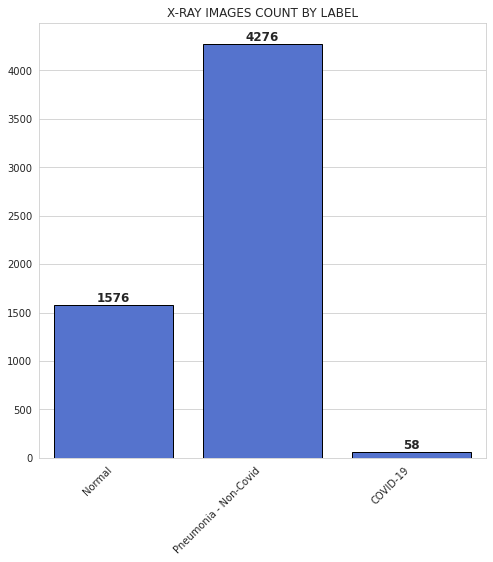

In [ ]:
#Plot 3 classifications
rcParams['figure.figsize'] = 8, 8

ax = sb.countplot(data=metadata, x = 'Label_xray', color='royalblue',
             edgecolor='black',linewidth=1).set_title('X-RAY IMAGES COUNT BY LABEL')

ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, horizontalalignment='right')
;

The data comes split into test and train. We look to see how the split is distributed

In [ ]:
#create test and train dataframes based on given splits
test_orig = metadata[metadata['Dataset_type'] == 'TEST']
train_orig = metadata[metadata['Dataset_type'] == 'TRAIN']
print(len(test_orig))
print(len(train_orig))

624
5286


In [ ]:
#check label distribution
print(f"Different values of labels distribution:\n{test_orig['Label_xray'].value_counts()}")

Different values of labels distribution:
Pneumonia - Non-Covid    390
Normal                   234
Name: Label_xray, dtype: int64


In [ ]:
print(f"Different values of labels distribution:\n{train_orig['Label_xray'].value_counts()}")

Different values of labels distribution:
Pneumonia - Non-Covid    3886
Normal                   1342
COVID-19                 58  
Name: Label_xray, dtype: int64


The given splits contain no COVID cases in the test data. To overcome this we will create our own train, test and validation dataframes

In [ ]:
# split the data into train and test set
train_df, test_df = train_test_split(metadata, test_size = 0.1, random_state = 20, shuffle=True)

In [ ]:
# split the train data into train and validation set
train_df, val_df = train_test_split(train_df, test_size = 0.1, random_state = 20, shuffle=True)

In [ ]:
#check our new test, validate and train dataframes
print(f"Test data label distribution:\n{test_df['Label_xray'].value_counts()}")

Test data label distribution:
Pneumonia - Non-Covid    419
Normal                   167
COVID-19                 5  
Name: Label_xray, dtype: int64


In [ ]:
print(f"Validation data label distribution:\n{val_df['Label_xray'].value_counts()}")

Validation data label distribution:
Pneumonia - Non-Covid    394
Normal                   132
COVID-19                 6  
Name: Label_xray, dtype: int64


In [ ]:
print(f"Train data label distribution:\n{train_df['Label_xray'].value_counts()}")

Train data label distribution:
Pneumonia - Non-Covid    3463
Normal                   1277
COVID-19                 47  
Name: Label_xray, dtype: int64


We now look at examples of the images

In [ ]:
test_dir ='/content/chack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_dir = '/content/chack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

uint8
(1482, 1989, 3)


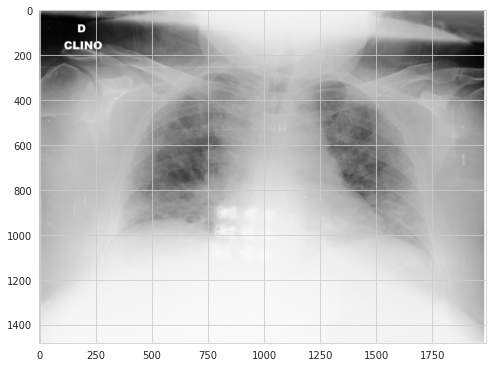

In [ ]:
#show a test image
data = image.imread(train_dir+'/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg')
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
plt.imshow(data)
plt.show()

uint8
(1317, 1857)


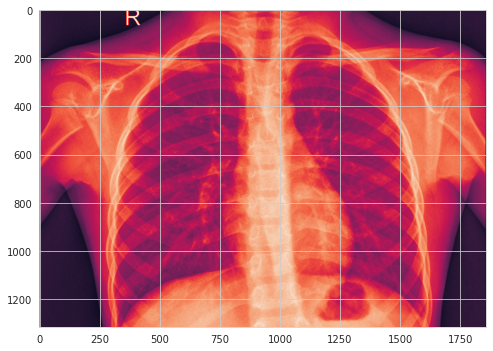

In [ ]:
#show a test image
data = image.imread(test_dir+'/IM-0001-0001.jpeg')
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
plt.imshow(data)
plt.show()

As the image files are in train and test folders based on a split we are not using, we move all images to a central folder

In [ ]:
#create a function to merge folders
def mergefolders(root_src_dir, root_dst_dir):
    for src_dir, dirs, files in os.walk(root_src_dir):
        dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        for file_ in files:
            src_file = os.path.join(src_dir, file_)
            dst_file = os.path.join(dst_dir, file_)
            if os.path.exists(dst_file):
                os.remove(dst_file)
            shutil.copy(src_file, dst_dir)

In [ ]:
#merge all files in test folder into train folder
mergefolders(test_dir, train_dir)

To increase our models ability to generalise, we use the ImageDataGenerator to slightly modify each image. This means the model will see new variations of the data at each epoch, resulting in an increased number of images being used in the training process. We also use the generator to normalize our data.

In [ ]:
#create a generator for the training data that performs augmentation and normalise
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

In [ ]:
#create a generator for the testing and validation data that only normalizes 
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#takes images from the central folder, that are in the train dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = "X_ray_image_name",
    y_col = "Label_xray",
    target_size = (256, 256),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    seed = 20,
    shuffle = True)

Found 4787 validated image filenames belonging to 3 classes.


In [ ]:
#takes images from the central folder, that are in the validation dataframe
val_generator = test_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_dir,
    x_col = "X_ray_image_name",
    y_col = "Label_xray",
    target_size = (256, 256),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    seed = 20,
    shuffle=False)

Found 532 validated image filenames belonging to 3 classes.


In [ ]:
#takes images from the central folder that are in the test dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = train_dir,
    x_col = "X_ray_image_name",
    y_col ="Label_xray",
    classes = ['Normal','COVID-19','Pneumonia - Non-Covid'],
    target_size = (256, 256),
    color_mode = "rgb",
    class_mode ="categorical",
    batch_size = 32,
    seed = 25,
    shuffle = False)

Found 591 validated image filenames belonging to 3 classes.


#CREATE MODEL#

We now define our model. We use the sequential API that allows us to create the model layer by layer.We then add the 1st convolutional layer setting the input size to match our image size. We use relu activation as it is not as computationally heavy as sigmoid activation and does not suffer from vanishing gradient problems.We set padding = same to ensure the ouput has the same dimensions as the input. We add batch normalization for regularization. We then use pooling to reduce the spatial dimenions of the output. We then add subsequent convolutional layers, varying the enumber of filters. We then flatten function to reshape the tensor, and add dense layers to have fully connected layers,adding dropouts to randomly ignore nuerons to improve generalization and reduce overfitting

In [ ]:
#create model
model = Sequential()

np.random.seed(0)
model = Sequential()

model.add(BatchNormalization(input_shape=(256,256,3)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(BatchNormalization(input_shape=(256,256,3)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(BatchNormalization(input_shape=(256,256,3)))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 64)     

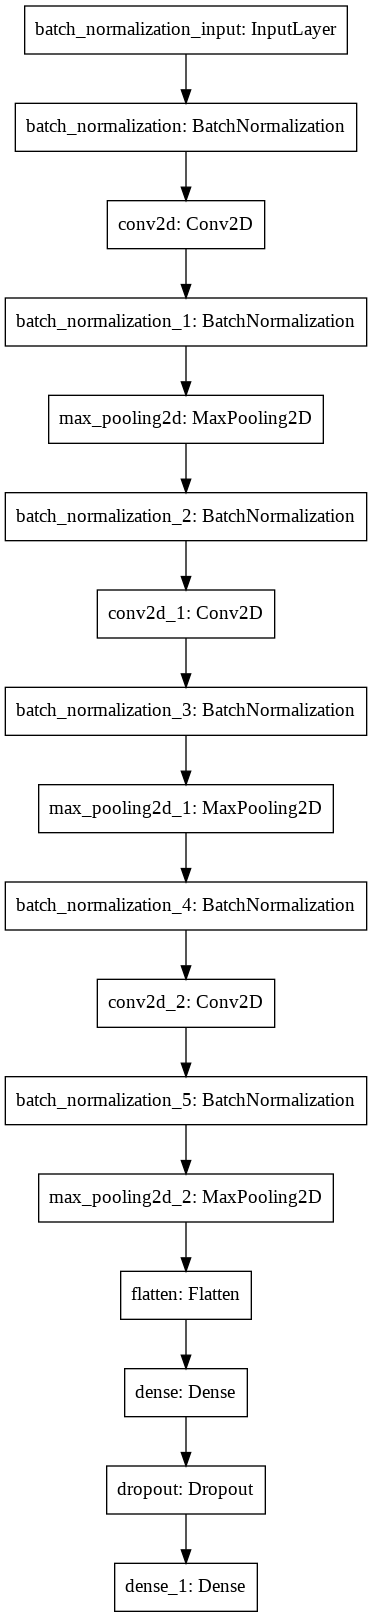

In [ ]:
keras.utils.plot_model(model)

In [ ]:
#As the data is imbalanced accuracy is not a good evaluater. We will define the metrics we want
METRICS = [
        keras.metrics.AUC(name = 'AUC'),
        keras.metrics.Precision(name = 'precision'),
        keras.metrics.Recall(name = 'recall')]

As the data is imbalanced we will use weights to stop the model over predicting the majority class.

In [ ]:
#calculate the weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)

In [ ]:
#create a dictionary for the weights
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
#display weights
class_weight_dict

{0: 33.95035460992908, 1: 1.2495432002088227, 2: 0.46077582057945904}

In [ ]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# autosave best Model
best_model_file = "best_model.h5"
best_model = keras.callbacks.ModelCheckpoint(best_model_file, monitor='val_recall', mode='max',verbose=1, save_best_only=True)

In [ ]:
#compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', 
              metrics = METRICS)

In [ ]:
#set constants
BATCH_SIZE = 32
EPOCHS = 18

In [ ]:
#run the model
hist = model.fit_generator(
           train_generator, 
           steps_per_epoch = train_generator.samples // BATCH_SIZE, 
           epochs = EPOCHS, validation_data=val_generator, 
           validation_steps = val_generator.samples // BATCH_SIZE,
           class_weight = class_weight_dict, callbacks=[earlyStopping, best_model])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/18
149/149 [==============================] - ETA: 0s - loss: 22.2949 - AUC: 0.7821 - precision: 0.6794 - recall: 0.6791
Epoch 00001: val_recall improved from -inf to 0.73242, saving model to best_model.h5
149/149 [==============================] - 109s 729ms/step - loss: 22.2949 - AUC: 0.7821 - precision: 0.6794 - recall: 0.6791 - val_loss: 7.3911 - val_AUC: 0.8227 - val_precision: 0.7324 - val_recall: 0.7324
Epoch 2/18
149/149 [==============================] - ETA: 0s - loss: 15.0450 - AUC: 0.8421 - precision: 0.7438 - recall: 0.7438
Epoch 00002: val_recall did not improve from 0.73242
149/149 [==============================] - 107s 718ms/step - loss: 15.0450 - AUC: 0.8421 - precision: 0.7438 - recall: 0.7438 - val_loss: 10.4267 - val_AUC: 0.7840 - val_precision: 0.6934 - val_recall: 0.6934
Epoch 3/18
149/149 [==============================] - ETA: 0s - loss: 7.2579 - AUC: 0.8587 - precision: 0.7396 

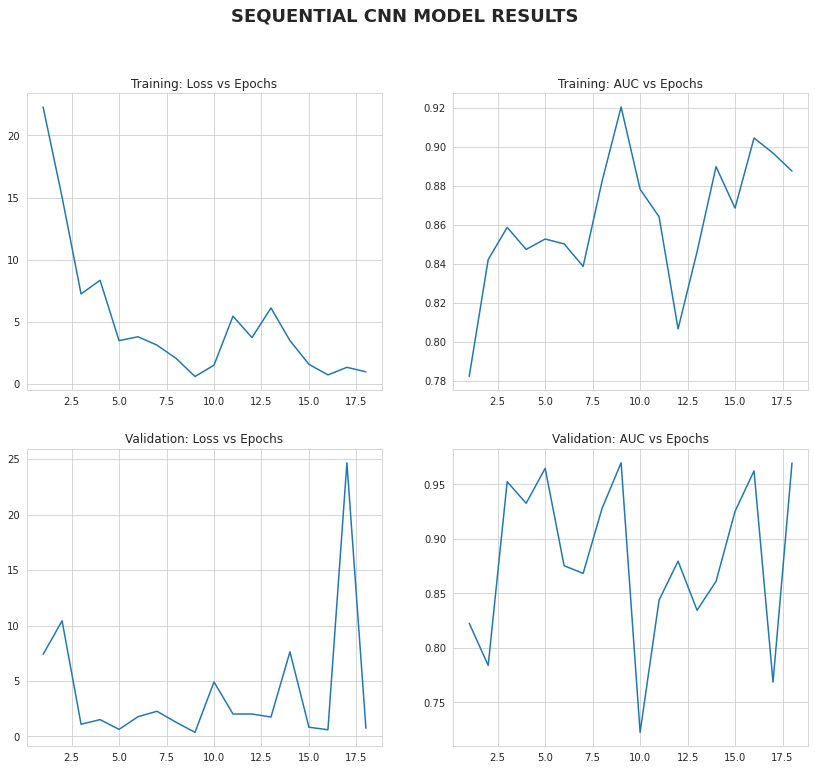

In [ ]:
#plot model results
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sb.lineplot(x=np.arange(1, 19), y=hist.history.get('loss'), ax=ax[0, 0])
sb.lineplot(x=np.arange(1, 19), y=hist.history.get('AUC'), ax=ax[0, 1])
sb.lineplot(x=np.arange(1, 19), y=hist.history.get('val_loss'), ax=ax[1, 0])
sb.lineplot(x=np.arange(1, 19), y=hist.history.get('val_AUC'), ax=ax[1, 1])
ax[0, 0].set_title('Training: Loss vs Epochs')
ax[0, 1].set_title('Training: AUC vs Epochs')
ax[1, 0].set_title('Validation: Loss vs Epochs')
ax[1, 1].set_title('Validation: AUC vs Epochs')
fig.suptitle('SEQUENTIAL CNN MODEL RESULTS', size=18, fontweight='bold')
plt.show()

In [ ]:
#load best weights
model.load_weights(filepath = 'best_model.h5')

In [ ]:
# evaluate model on test data
test_loss, test_AUC, test_precision, test_recall = model.evaluate(test_generator)

19/19 [==============================] - 6s 331ms/step - loss: 1.0881 - AUC: 0.9607 - precision: 0.8866 - recall: 0.8866


In [ ]:
#make predictions on test data
test_generator.reset()
pred= model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[1 2 2 2 2 2 2 2 2 2 1 0 1 2 2 1 2 2 2 2 0 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 1
 1 2 2 2 1 2 1 2 2 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 2 2 2 1 2 1 1 2 2 2 2 1 1
 1 2 2 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 2 2 2 2 1 1 2 2 1 2 1 2 2 1 2
 1 2 2 1 2 1 1 2 2 2 2 1 1 2 2 2 1 2 2 2 1 1 1 2 1 1 2 1 2 1 2 2 1 2 1 1 1
 1 1 2 2 0 1 2 1 2 1 1 1 2 2 2 1 2 1 2 2 2 0 2 1 2 2 1 2 2 1 1 1 2 2 2 2 1
 1 2 2 1 2 1 1 2 1 1 1 2 0 2 1 1 1 2 1 1 1 1 2 2 2 2 2 2 1 2 1 2 1 2 2 2 2
 1 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 1 2 2 0 1 1 2 1 2 2 1 2 1 2 2 2 1 2 2 2 1
 2 2 1 2 2 2 2 1 2 2 2 2 1 0 2 1 2 2 2 2 1 2 1 2 2 2 1 1 2 2 1 2 2 2 1 2 2
 2 2 2 2 1 1 2 2 2 1 1 1 2 2 1 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2
 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 1 2 2 1 2 2 2 1 2 2 2 0 1 2 2 1
 2 2 2 2 1 1 2 2 2 1 2 1 1 2 2 1 2 2 2 1 2 1 2 1 2 2 2 1 1 2 2 2 2 2 2 2 1
 1 2 2 1 1 1 2 1 1 1 2 2 1 2 2 2 0 1 2 1 2 2 1 2 2 1 1 1 2 1 1 2 0 2 1 1 2
 1 2 1 1 2 2 2 1 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 1 2 1 0 2 2 2 2 2 2 2 1
 2 1 1 2 2 0 2 2 2 2 2 2 

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix


<function matplotlib.pyplot.show>

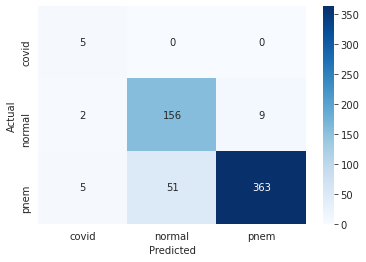

In [ ]:
#create confusion matrix and classification report to evaluate the perfomance on test data
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
target_names = ['covid', 'normal', 'pnem']
print('Confusion Matrix')
#print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,xticklabels=target_names, yticklabels=target_names,cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [ ]:
print('Classification Report')
print(classification_report(test_generator.classes, predicted_class_indices, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.42      1.00      0.59         5
      normal       0.75      0.93      0.83       167
        pnem       0.98      0.87      0.92       419

    accuracy                           0.89       591
   macro avg       0.72      0.93      0.78       591
weighted avg       0.91      0.89      0.89       591



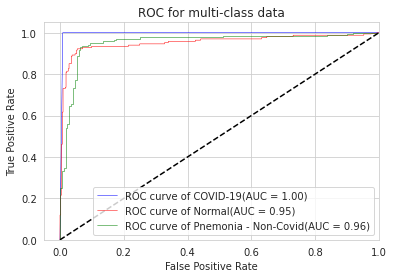

In [ ]:
#create ROC curve
y = train_df['Label_xray'].values
# Binarize the output
y = label_binarize(y_true, classes=[0,1,2])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(y[:,i], Y_pred[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red', 'green']
cls = {0:'COVID-19', 1:'Normal', 2:'Pnemonia - Non-Covid'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.5,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()